# Seminar - Bank Marketing Dataset

During this seminar we will be analysing [this dataset](https://archive.ics.uci.edu/dataset/222/bank+marketing).

The goal is to fit two models - a very simple decision tree and a random forest, compare those models via cross validation and then evaluate the best model on a holdout set.


In [1]:
import pandas as pd
import numpy as np
import zipfile
import urllib
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import tree
import warnings

warnings.filterwarnings("ignore")

In [2]:
def plot_tree(model, features):
    plt.figure(figsize=(15, 10))
    tree.plot_tree(
        model,
        feature_names=features,
        proportion=True,
        precision=2,
        filled=True,
    )
    plt.show()

In [3]:
url = "https://archive.ics.uci.edu/static/public/222/bank+marketing.zip"
urllib.request.urlretrieve(url, "bank_marketing.zip")

with zipfile.ZipFile("bank_marketing.zip", "r") as zip_ref:
    zip_ref.extractall("bank_marketing")

with zipfile.ZipFile("bank_marketing/bank.zip", "r") as zip_ref:
    zip_ref.extractall("bank_marketing")

In [4]:
df = pd.read_csv("bank_marketing/bank-full.csv", sep=";")

In [5]:
df = df[["balance", "housing", "loan", "job", "age", "campaign", "previous", "y"]]

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   balance   45211 non-null  int64 
 1   housing   45211 non-null  object
 2   loan      45211 non-null  object
 3   job       45211 non-null  object
 4   age       45211 non-null  int64 
 5   campaign  45211 non-null  int64 
 6   previous  45211 non-null  int64 
 7   y         45211 non-null  object
dtypes: int64(4), object(4)
memory usage: 2.8+ MB


In [7]:
df["y"] = df["y"].map({"yes": 1, "no": 0})

In [8]:
df.value_counts("y")

y
0    39922
1     5289
Name: count, dtype: int64

In [9]:
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)

### Task 1: plotting

- Create plots showing the distribution of `balance` and `age` by `y`.
- Show average of `y` (share of cases where y=1) by `job`.



Text(0.5, 0, 'Age')

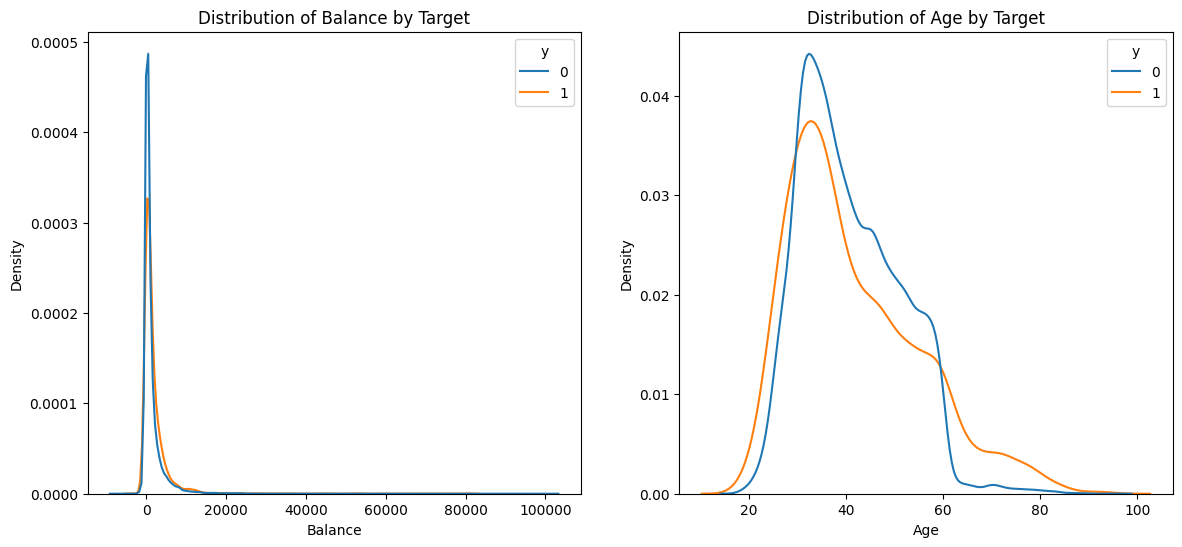

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

sns.kdeplot(data=df_train, x="balance", hue="y", ax=axes[0], common_norm=False)
axes[0].set_title("Distribution of Balance by Target")
axes[0].set_xlabel("Balance")

sns.kdeplot(data=df_train, x="age", hue="y", ax=axes[1], common_norm=False)
axes[1].set_title("Distribution of Age by Target")
axes[1].set_xlabel("Age")

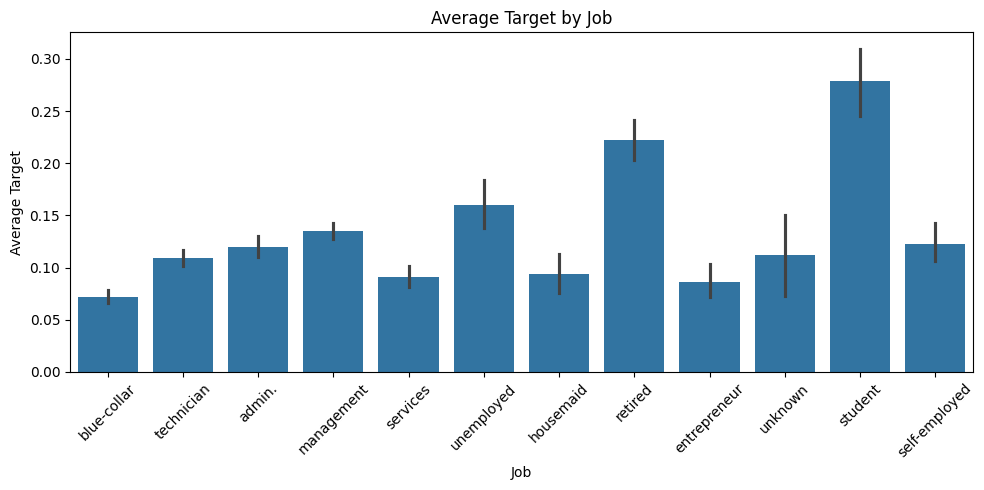

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

sns.barplot(data=df_train, x="job", y="y")
ax.set_title("Average Target by Job")
ax.set_xlabel("Job")
ax.set_ylabel("Average Target")
ax.tick_params(axis="x", rotation=45)

plt.tight_layout()

### Task 2: Decision tree

- Fit a decision tree model using `balance` and `age` features. Set `max_depth` to 2.
- Evaluate the model using cross-validation (`cross_val_score`), once using "accuracy" and once using "roc_auc" as the metric.
- Visualize the decision tree using `plot_tree` function.


In [12]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score

X_train_bal_age = df_train[["balance", "age"]]
y_train = df_train["y"]

dec_model = DecisionTreeClassifier(max_depth=2)
dec_model.fit(X_train_bal_age, y_train)

accuracy_mean = np.mean(
    cross_val_score(dec_model, X_train_bal_age, y_train, cv=10, scoring="accuracy")
)
roc_auc_mean = np.mean(
    cross_val_score(dec_model, X_train_bal_age, y_train, cv=10, scoring="roc_auc")
)

print(f"Accuracy: {accuracy_mean:.4f}")
print(f"ROC AUC: {roc_auc_mean:.4f}")

Accuracy: 0.8839
ROC AUC: 0.5741


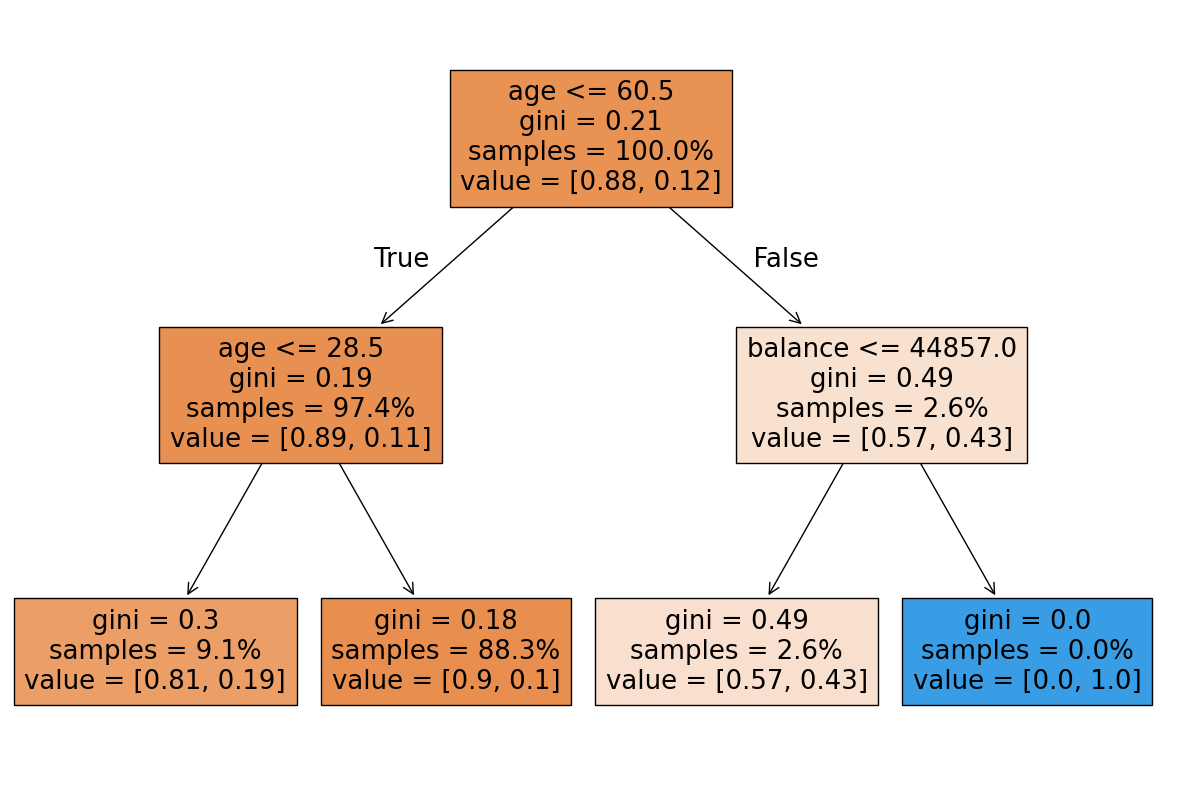

In [13]:
plot_tree(dec_model, X_train_bal_age.columns)

### Task 3: Random forest

- Fit a random forest with instead of a single decision tree, using the two features from above.
- Find optimal parameters for `max_depth` and `class_weight`. Show the performance on the model using the best hyperparameters. For `max_depth` use a range of 1 to 20 (inclusive).

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier()
rf_model.fit(X_train_bal_age, y_train)

RandomForestClassifier()

In [15]:
from sklearn.model_selection import GridSearchCV

param_grid = {"max_depth": range(1, 21), "class_weight": ["balanced", None]}

grid_search = GridSearchCV(rf_model, param_grid, cv=5, scoring="roc_auc", n_jobs=-1)
grid_search.fit(X_train_bal_age, y_train)

print(grid_search.best_params_)
print(grid_search.best_score_)

{'class_weight': None, 'max_depth': 10}
0.647828596701108


### Task 4: Random forest, all features

- Add all features to the model.
- Tune `max_depth`, `class_weight` and `min_samples_split` hyperparameters. For `max_depth` use a range of 10 to 20 (inclusive), for `min_samples_split` use a range of 2 to 10 (inclusive).

- Compare the first model (decision tree) to this model.

Note - hyperparameter tuning takes some time! To speed it up simple reduce the range of parameters you're searching over.


In [16]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

X_train = df_train.drop(columns=["y"])
y_train = df_train["y"]

categorical_preprocessor = ColumnTransformer(
    transformers=[
        (
            "cat",
            OneHotEncoder(handle_unknown="ignore", max_categories=10),
            ["job", "housing", "loan"],
        )
    ],
    remainder="passthrough",
)

rf_model2 = Pipeline(
    steps=[("preprocessor", categorical_preprocessor), ("rf", RandomForestClassifier())]
)

In [17]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    "rf__max_depth": range(10, 21),
    "rf__class_weight": ["balanced", None],
    "rf__min_samples_split": range(2, 10),
}

grid_search = GridSearchCV(rf_model2, param_grid, cv=5, scoring="roc_auc", n_jobs=-1)
grid_search.fit(X_train, y_train)

print(grid_search.best_params_)

{'rf__class_weight': None, 'rf__max_depth': 10, 'rf__min_samples_split': 5}


In [ ]:
rf_score = np.mean(
    cross_val_score(rf_model2, X_train, y_train, cv=5, scoring="roc_auc")
)
dec_score = np.mean(
    cross_val_score(dec_model, X_train_bal_age, y_train, cv=5, scoring="roc_auc")
)

In [ ]:
print(rf_score)
print(dec_score)

0.667996279905872
0.57372807171833


In [26]:
best_model = grid_search.best_estimator_
# or refit the model with best parameters
# (better option since you would be retraining with the whole dataset)
best_model = Pipeline(
    steps=[
        ("preprocessor", categorical_preprocessor),
        (
            "rf",
            RandomForestClassifier(
                class_weight=None, max_depth=10, min_samples_split=5
            ),
        ),
    ]
)
best_model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                max_categories=10),
                                                  ['job', 'housing',
                                                   'loan'])])),
                ('rf',
                 RandomForestClassifier(max_depth=10, min_samples_split=5))])

### Task 5: Report the performance of the best model

- Show how precision, recall and F1 score change as you change the threshold
- On a separate plot, show how the number of positive predictions (the number of cases where model prediction exceeds the threshold) changes as a function of the threshold

Interpret the plots. Try to pretend that you're working in a bank and are creating this model for the marketing team. What would you communicate to the stakeholders in the team?


<Axes: xlabel='threshold', ylabel='count_positive'>

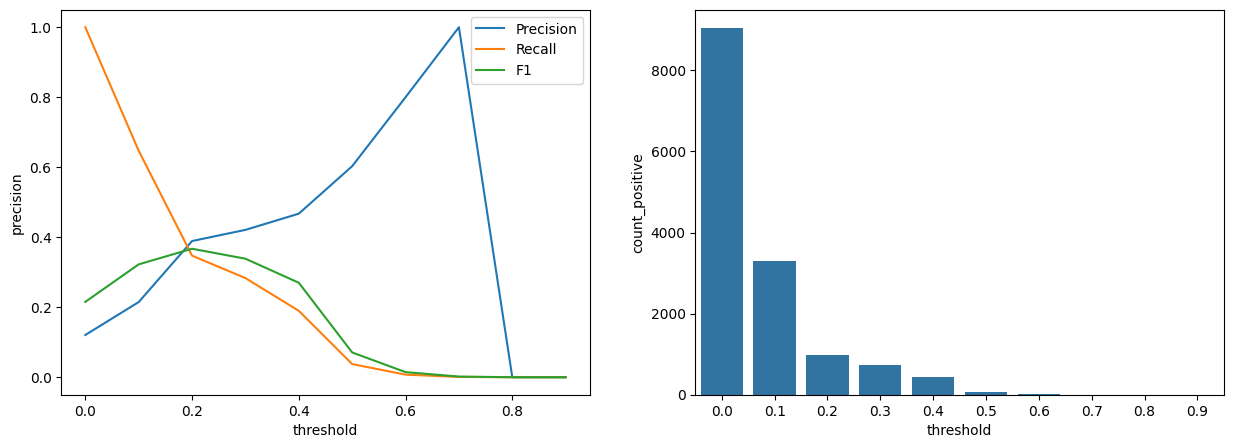

In [27]:
from sklearn.metrics import precision_score, recall_score, f1_score

fig, axs = plt.subplots(1, 2, figsize=(15, 5))

X_test = df_test.drop(columns=["y"])
y_test = df_test["y"]

thresholds = np.arange(0, 1, 0.1).round(1)
metrics = []

for threshold in thresholds:
    y_pred = (best_model.predict_proba(X_test)[:, 1] > threshold).astype(int)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    metrics.append(
        {
            "threshold": threshold,
            "precision": precision,
            "recall": recall,
            "count_positive": np.sum(y_pred),
            "f1": f1,
        }
    )

metrics = pd.DataFrame(metrics)
metrics

sns.lineplot(data=metrics, x="threshold", y="precision", label="Precision", ax=axs[0])
sns.lineplot(data=metrics, x="threshold", y="recall", label="Recall", ax=axs[0])
sns.lineplot(data=metrics, x="threshold", y="f1", label="F1", ax=axs[0])
sns.barplot(data=metrics, x="threshold", y="count_positive", ax=axs[1])